# Stacking Multiple Time Series models using Genetic Algorithm 

**Purpose:** This Jupyter Notebook aims at stacking multiple predictions from Holt Winters, Prophet, Seasonal Arima to arrive at a prediction with better accuracy. The forecasts are created using 3 different time 
series models and then the results are ensembled using genetic algorithm to optimize the weights on each 
model prediction. The final predictions are a linear combination of the model predictions and the optimum weights 
for each of them.</p>

**Usage:** This method can be used in cases where individual time series models can be combined to provide further good predictions on univariate cases. This version looks at the univariate time series only. However the ensemble/stacking approach can be extended to other cases also. </p>

**Dated:** 01/21/2020

**Author:** Aditi Raha, Atrijit Ghosh

- ##### **Algorithms included in this notebook**
    - Holt-Winter's Forecasting
    - Seasonal ARIMA (Seasonal AutoRegressive Integrated Moving Average) Forecasting
    - Prophet Forecasting
    - Genetic Algorithm
    
 All assumptions involved within each method is discussed at later sections. Initial checks for such assumptions has also been provided, which should be tested against the data by the user.

- ##### **Data Used**
    - Airpassengers Data (present within the R environment)

- ##### **Note**
     - In this notebook a univariate time series is used, but the solution can also be extended in cases where there is a multivariate time series. Accordingly all the forecasting algorithms can be used and then combined using genetic algorithm 
     - The objective of the notebook is not to fit a good holt winters/prophet/SARIMA model
     - The main objective here is how to stack/ensemble them using Genetic Algorithm
     - It will allow the user to understand how a weighted ensembled forecast is better than just simple average forecast or any standalone model.
     - We have used GA as the optimizer, but one can also use any other algorithm for the same
     - One must also consider more data points for validation, so that there is no overfitting
    

- ##### **Limitations**
     - This notebook attempts in improving 3 or  models with the help of stacking. The solution serves best only and only when we have different models with the accuracy measures in the same vicinity. And also when the limitations of one model can be complemented with another model
     - The model building procedure is equally important and the parameters shall vary according to the pattern of the data used.
     - User must be acquainted with prior knowledge of the time series modelling techniques and their usability in varied scenarios and also genetic algorithm.
     - A model stacking/ensembling does not always guarantee an improved forecast. If however, there are models out of which one of them has an accuracy significantly better than the others then user must proceed with the best model and not stacking.
     
- ##### **Resources/ Further Study Materials**
    - https://en.wikipedia.org/wiki/Exponential_smoothing
    - https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average
    - https://towardsdatascience.com/forecasting-with-prophet-d50bbfe95f91
    - https://en.wikipedia.org/wiki/Genetic_algorithm
    - https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    - https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
    - https://cran.r-project.org/web/packages/GA/vignettes/GA.html
    
# Dependencies

Load the dependencies for model development. Current package requirements include:
* R
* forecast
* ggplot2
* prophet
* GA
* dplyr
* data.table
* e1071
* tseries
* zoo
* aTSA
* astsa
      


# Installing and Loading Required Libraries
 
Load all the libraries, if any library is not present, install the same using install.packages function in R

In [1]:
cat("\014")
rm(list = ls())
#package list required 
libs <- c("dplyr", "data.table", "forecast", "prophet", 'ggplot2', 'GA', 'zoo', 'tseries','aTSA','astsa')
# loading all the required packages within the environment
lapply(libs, require, character.only = T)

Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: data.table

Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

Loading required package: forecast
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff
Loading required package: prophet
Loading required package: Rcpp
Loading required package: rlang

Attaching package: 'rlang'

The following object is masked from 'package:data.table':

    :=

Loading required package: ggplot2
Loading required package: GA
Loading re

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

### Package Installation example in R 

In [2]:
# remove the comment if needed to run (if the package is not there in the list) 
#install.packages("GA")

# 1. Data Load Function

The file we are using here is already there in forecast package, but one can also load the dataset using "read.csv" or "fread", functions. "fread" function is there in data.table package.

**Example:** data <- fread("C:\self\data.csv", header = T)

#  2. Plotting Time Series

In [3]:
## managing the size of inline plot
options(repr.plot.width=5, repr.plot.height=5)

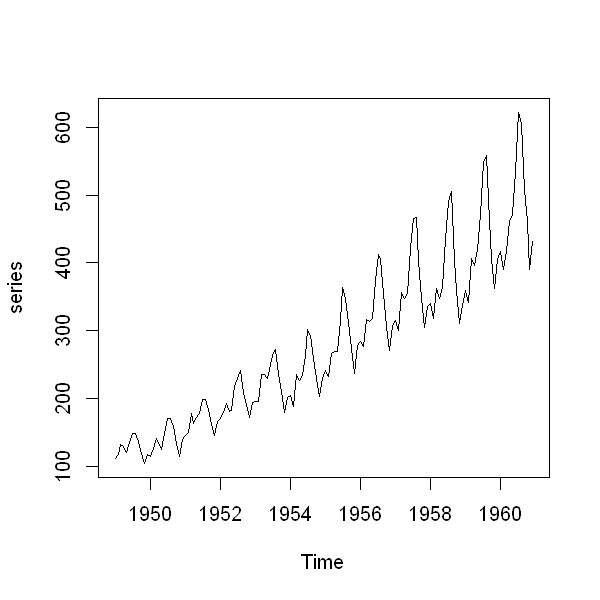

In [4]:
## Loading the dataset
## ------------------------------------------------------------------------------------------------------------------
series = AirPassengers
# plot time series 
plot.ts(series)

#### Define the frequency of time series 

**Note:** The AirPassengers data set is a monthly total of international passengers from 1949 to 1960, hence the frequency of time series will be 12

Frequency : the number of observations per unit of time.

# 3. Decomposing the components in a Time Series
<p style = 'text-align: justify;'> A univariate time series usually consists of 4 different components namely:

  - **Level**: The average value in the series
  - **Trend**: The increasing or decreasing pattern inherent within the series
  - **Seasonality**: The systematic repitition of a short term cycle
  - **Noise**: The random variation in the series
  
Out of these 4 components, the first 3 are systematic components which can be accounted for in a model whereas the last component is a non-systematic behaviour and usually cannot be captured within a model.
Decomposing a time series is important in the sense that it gives the user an idea of how to best capture these components in a model.

Here we aim to decompose the time series using the **decompose()** function in R.
 - **Inputs**:
   - univariate time series ( as a vector)
   - series type to be mentioned within quotes ( whether 'additive' or 'multiplicative' : to be inferred from previous graph)
   
 - **Output**:
   - the plot would be generated with the 4 components as present in the series </p>


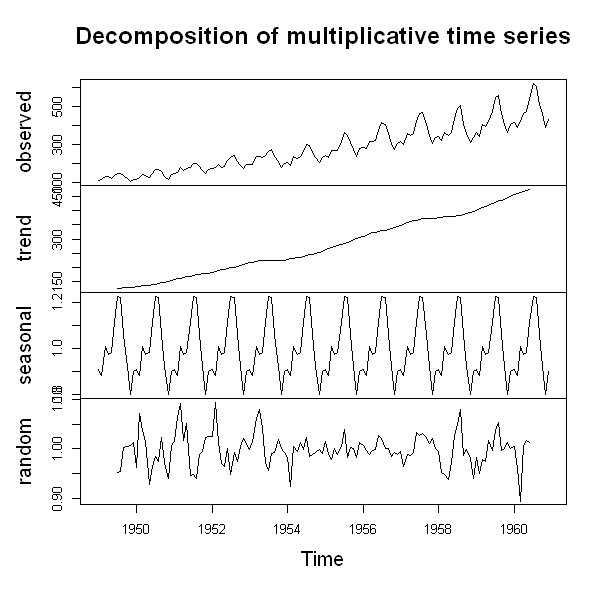

In [5]:
decompose(series, type = 'multiplicative' ) %>% plot()

# 4. Splitting the data

<p style = 'text-align: justify;'>Since the modelling is aimed at improving forecasting results than each of the models alone, for validating the hypothesis we shall divide the time series data into train and test sets. The following functions can be used to split the data:</p>

 - **Inputs**:
  - **Data**: the time series
  - **n_step_ahead**: number of rows the user wants to keep as a test set
  
 ##### **Note**: The conventional method demands test data to have 20-30% of the data. But this number might vary depending on the user's intuition.
 
 - **Outputs**: Test and Train datasets
 

In [6]:
##Train-test Split
## time for forecast (same as the test data, this is for validation)
n_step_ahead = 24
## test data
test_series = tail(series,n_step_ahead)
## train data
train_series = series[-test_series]
## specify time for the train values
train_series = ts(train_series,frequency = 12,start = c(1949,1) ,end = c(1958,12))

# 5. Error Metric - MAPE

Ref: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

In [7]:
## Define function to calculate MAPE
mape = function(forecast,actual){100*(sum(abs((actual-forecast)/actual))/length(actual))}

# 6. Holt-Winters

Holt Winters method is also known as the Triple Exponential Smoothing Method which is used when the data has both trend and seasonality. This method is an extension of the Exponential Smoothing which explicitly adds support for the seasonality component in univariate time series. 

#### The three important hyperparameters in Holt Winters model are:
 - Alpha : smoothing factor for level
 - Beta  : smoothing factor for trend
 - Gamma : smoothing factor for seasonal component
 
In addition to the above hyperparemeters, seasonality type should also be mentioned, i.e. whether additive or multiplicative.

Ref: https://en.wikipedia.org/wiki/Exponential_smoothing


##### The final model parameters chosen here are arrived at after few iterations and some 'trial and error'. User must choose parameters that fits the data best. 

Holt-Winters exponential smoothing with trend and multiplicative seasonal component.

Call:
HoltWinters(x = train_series, alpha = 0.5, beta = 0.2, seasonal = "multiplicative")

Smoothing parameters:
 alpha: 0.5
 beta : 0.2
 gamma: 0.9999339

Coefficients:
           [,1]
a   407.1359993
b     4.7956669
s1    0.8676820
s2    0.8350437
s3    0.9865740
s4    0.9857500
s5    1.0441750
s6    1.2446200
s7    1.3631286
s8    1.3229302
s9    1.0450323
s10   0.8961273
s11   0.7599654
s12   0.8277342


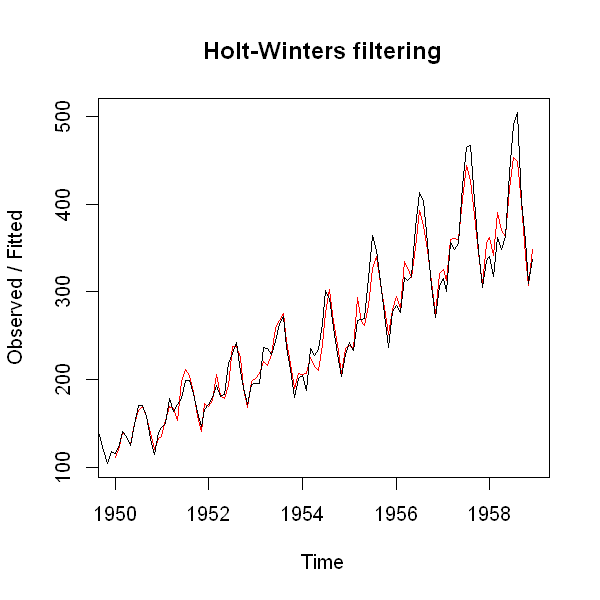

In [8]:
## HoltWinters- Model building
## ----------------------------------------------------------------------------------------------------------------------------
hw_model = HoltWinters(train_series, seasonal = 'multiplicative', alpha = .5, beta = .2)
print(hw_model)
plot(hw_model)

#### Forecast and plot the series for next 24 months 

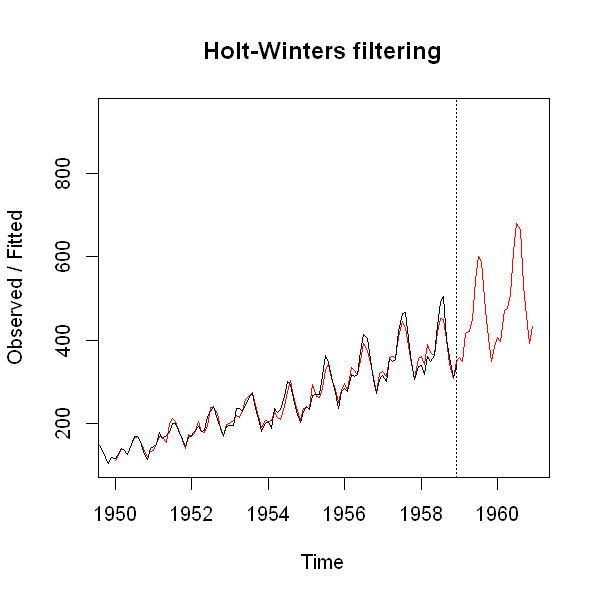

In [9]:
## forecast using holt winters 
forecasted_hw = forecast::forecast(hw_model, h = n_step_ahead)
## save the forecast in a dataframe 
forecasted_hw = as.data.frame(forecasted_hw)
## plot the forecast
plot(hw_model,forecasted_hw)

##### Error calculations for Holt winters 

In [10]:
## for details refer to section 5 
hw_mape= mape(forecasted_hw$`Point Forecast`,test_series)
hw_mape

[1] 5.250456

# 7. SARIMA

SARIMA stands for Seasonal Auto Regressive Integrated Moving Average which tries to 
explain a time series based on its own lag values having a seasonal component.

#### Model parameters:
 - Trend Elements
    - p : order of the Autoregressive Term
    - d : order of differencing
    - q : order of the Moving average term.
 - Seasonal Elements
    - P : Seasonal Autoregressive Order
    - D : Seasonal Differencing Order
    - Q : Seasonal Moving Average Order
    - m : number of time steps for a single seasonal period

Usually time series used should be stationary in the sense that it is not autocorrelated with its past values.
A series is made stationary by differencing that is subtracting it from the past values. 
**The initial idea about the order of differencing as well as the values of 'p','q','P','Q' and 'm' are detremined from the ACF and PACF plots. Although user should ideally run a grid search through the probable parameters of the model and then decide upon the best model using MAPE values or any other error method**

The SARIMA model is portrayed here.

Ref: https://medium.com/@kfoofw/seasonal-lags-sarima-model-fa671a858729


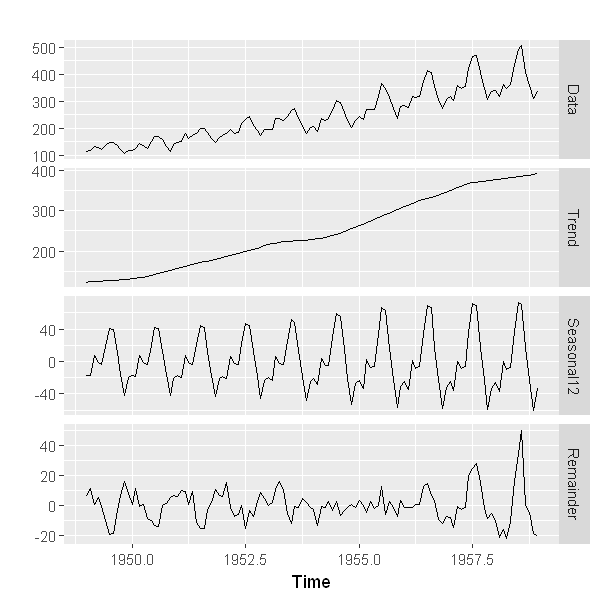

In [11]:
# mstl() function from forecast package gives an idea whether there are multiple levels of seasonality
#plot the graphs
train_series %>%  mstl() %>% autoplot()

Conclusion: seasonality at 12months time period exists

#### ADF test for stationarity
Here the Null hypothesis is that stationarity does not exist and alternative is stationarity exists

Ref: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

In [12]:
adf.test(train_series)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag     ADF p.value
[1,]   0  0.0174   0.648
[2,]   1 -0.3190   0.552
[3,]   2 -0.0311   0.634
[4,]   3  0.1987   0.700
[5,]   4  0.8438   0.884
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -1.83   0.396
[2,]   1 -2.35   0.193
[3,]   2 -1.87   0.381
[4,]   3 -1.64   0.467
[5,]   4 -1.05   0.679
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -4.20    0.01
[2,]   1 -6.93    0.01
[3,]   2 -6.46    0.01
[4,]   3 -6.42    0.01
[5,]   4 -5.24    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


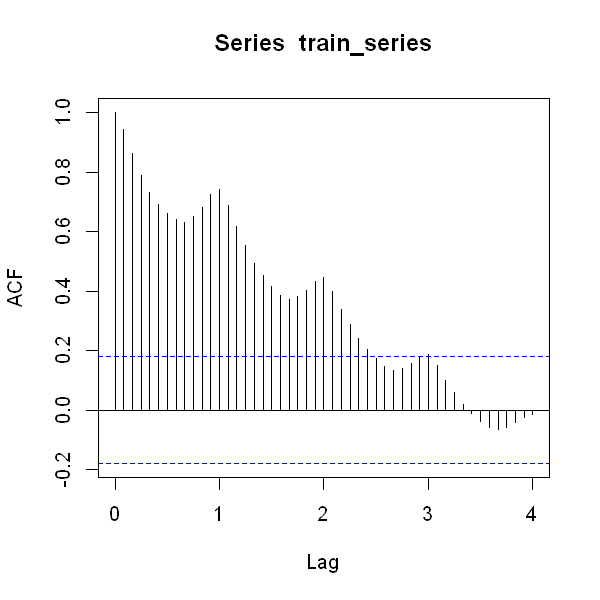

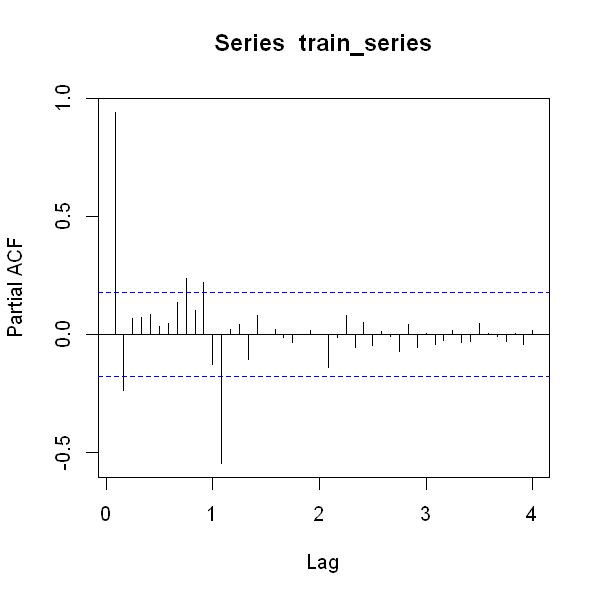

In [13]:
#examine the ACF and PACF of the series
acf(train_series,48)
pacf(train_series,48)

Conclusion: sinusoidal pattern of ACF says seasonality might be present

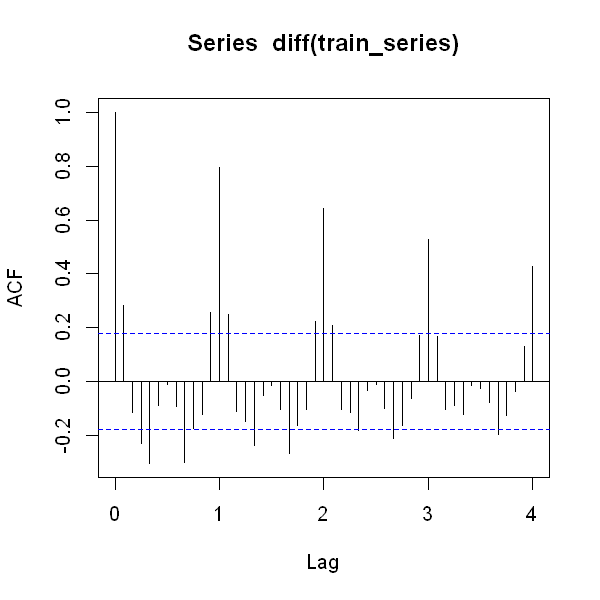

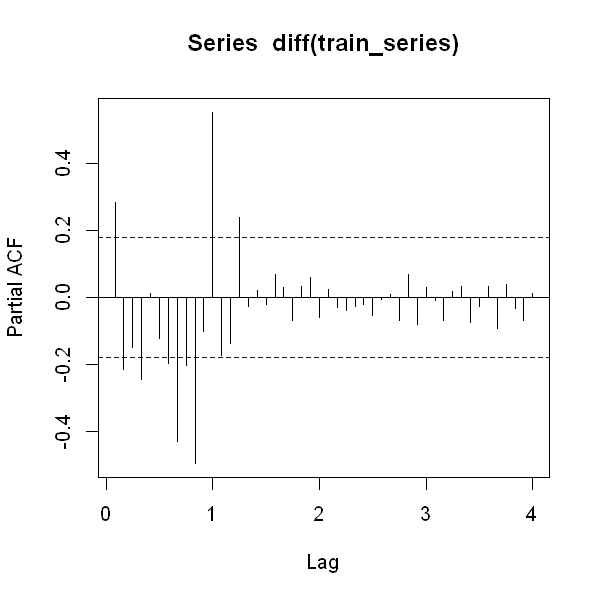

In [14]:
# examine the ACF plot of first order differenced series
acf(diff(train_series),48)
pacf(diff(train_series),48)

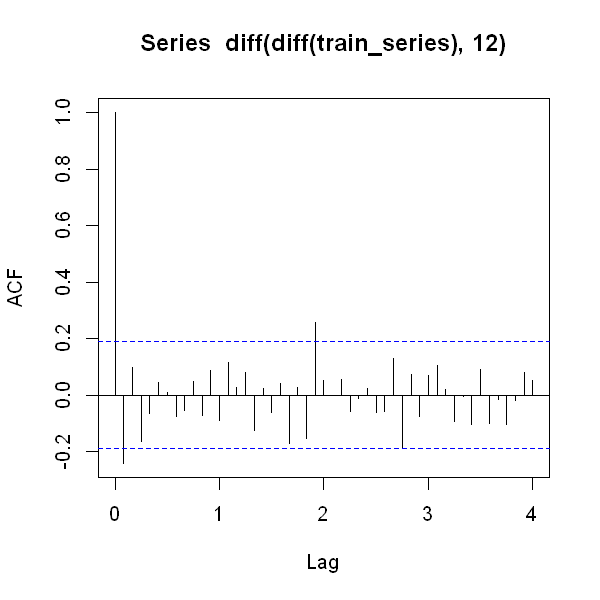

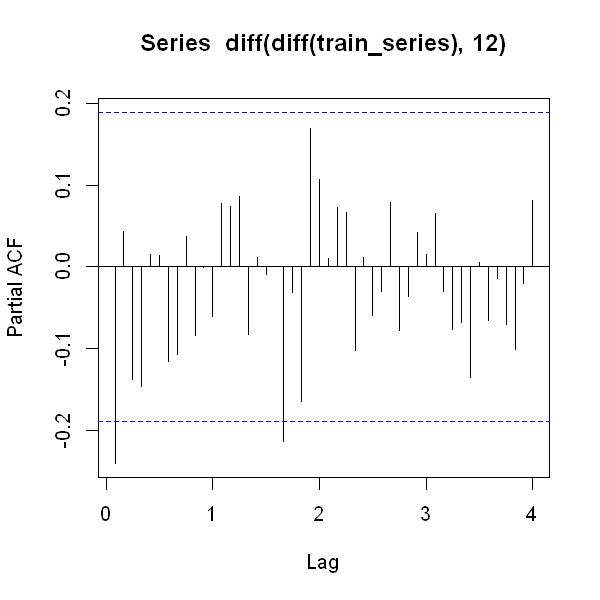

In [15]:
#examine the ACF and PACF after applying both a non-seasonal and seasonal difference to the data 
acf(diff(diff(train_series),12),48)
pacf(diff(diff(train_series),12),48)


In [16]:
## base SARIMA model
sarima_model_base = auto.arima(train_series)
sarima_model_base

Series: train_series 
ARIMA(1,1,0)(0,1,0)[12] 

Coefficients:
          ar1
      -0.2397
s.e.   0.0935

sigma^2 estimated as 103.6:  log likelihood=-399.64
AIC=803.28   AICc=803.4   BIC=808.63

#### Deciding on the model parameters
The above graphs would give an idea of what the model parameters should be. 

**Note:** The ACF and PACF provide an idea of what the parameters might be. It is advisable to grid search over the parameters for the best fit. 

Here we are using a SARIMA (p,d,q)(P,D,Q)[m] : (2,1,2)(1,1,1)[12]

Ref: https://otexts.com/fpp2/seasonal-arima.html


initial  value 2.385160 
iter   2 value 2.360919
iter   3 value 2.348903
iter   4 value 2.345252
iter   5 value 2.332181
iter   6 value 2.324580
iter   7 value 2.305284
iter   8 value 2.297343
iter   9 value 2.296131
iter  10 value 2.295480
iter  11 value 2.294926
iter  12 value 2.294681
iter  13 value 2.293848
iter  14 value 2.293696
iter  15 value 2.293672
iter  16 value 2.293638
iter  17 value 2.293624
iter  18 value 2.293606
iter  19 value 2.293599
iter  20 value 2.293590
iter  21 value 2.293578
iter  22 value 2.293575
iter  23 value 2.293574
iter  24 value 2.293574
iter  25 value 2.293574
iter  25 value 2.293574
iter  25 value 2.293574
final  value 2.293574 
converged
initial  value 2.313812 
iter   2 value 2.313476
iter   3 value 2.304096
iter   4 value 2.303654
iter   5 value 2.303269
iter   6 value 2.299624
iter   7 value 2.297036
iter   8 value 2.295589
iter   9 value 2.295519
iter  10 value 2.294431
iter  11 value 2.294345
iter  12 value 2.294066
iter  13 value 2.292831
iter 

$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), include.mean = !no.constant, transform.pars = trans, fixed = fixed, 
    optim.control = list(trace = trc, REPORT = 1, reltol = tol))

Coefficients:
         ar1     ar2      ma1      ma2     sar1    sma1
      0.3039  0.4895  -0.6167  -0.3832  -0.8955  0.8394
s.e.  0.3009  0.2435   0.3256   0.3236   0.4449  0.5194

sigma^2 estimated as 94.6:  log likelihood = -396.67,  aic = 807.33

$degrees_of_freedom
[1] 101

$ttable
     Estimate     SE t.value p.value
ar1    0.3039 0.3009  1.0099  0.3150
ar2    0.4895 0.2435  2.0106  0.0470
ma1   -0.6167 0.3256 -1.8944  0.0610
ma2   -0.3832 0.3236 -1.1844  0.2391
sar1  -0.8955 0.4449 -2.0129  0.0468
sma1   0.8394 0.5194  1.6162  0.1092

$AIC
[1] 6.8418

$AICc
[1] 6.848213

$BIC
[1] 7.000358


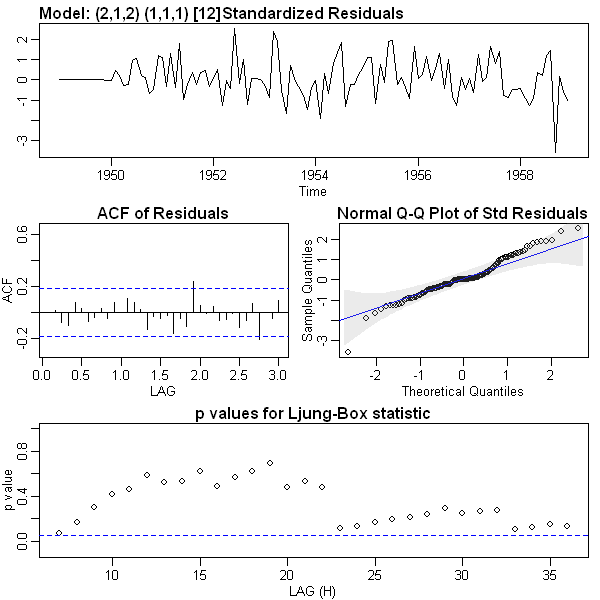

In [17]:
# building the SARIMA
sarima_model = sarima(train_series , p = 2, d = 1 , q = 2 , P = 1, D = 1 , Q = 1 , S = 12)
#view model summary 
sarima_model

**Better model than the base model if compared in terms of the mape values**

[1] 9.38402

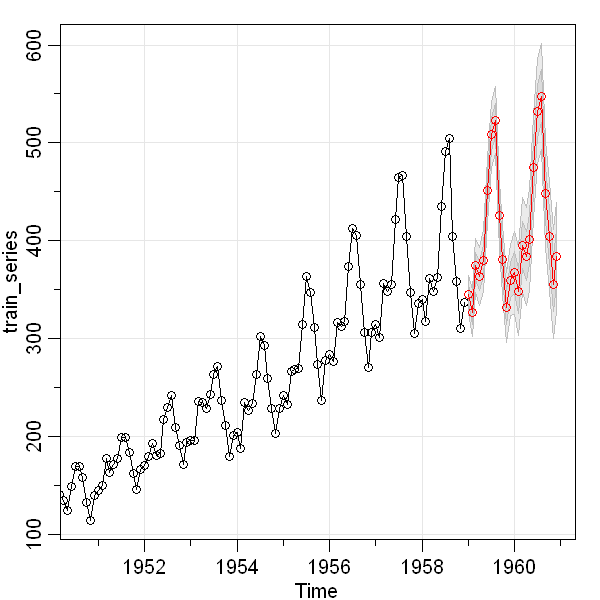

In [18]:
### forecast using the SARIMA model
sarima_forecast = sarima.for(train_series,n.ahead = n_step_ahead, p = 2, d = 1, q = 2, P = 1, D = 1, Q = 1, S = 12)$pred

#convert the forcasted series as dataframe
sarima_forecast = as.data.frame(sarima_forecast)
#calculate MAPE with the test data set
sarima_mape = mape(sarima_forecast$x , test_series)
#print MAPE and the plot for the forecast with the confidence inetrvals
sarima_mape


# 8. Prophet

Prophet is essentially a method developed by the Facebook to produce forecasts for various businesses.
It is unique since it accounts for the holidays or large events that might impact businesses.

#### Model parameters:

    - g(t) : models trend .
    - s(t) : is for modelling seasonality with the Fourier series.
    - h(t) : accounts for effects of holidays or large events 

      finally e(t) represents the noise or an error term
      
Ref: https://towardsdatascience.com/forecasting-with-prophet-d50bbfe95f91

In [19]:
## Prophet takes dataframes with specific column names where the datetime is called `ds` and the target is called `y`
prophet_series = data.frame(ds = as.Date(time(series)),
                            y = coredata(series))
prophet_test = tail(prophet_series,n_step_ahead)
prophet_train = anti_join(prophet_series , prophet_test)

Joining, by = c("ds", "y")


In [20]:
## mention all the seasonality & trend parameters
yearly_seasonality = TRUE
weekly_seasonality = FALSE
daily_seasonlity = FALSE
seasonality_type = 'multiplicative'
trend_type = 'linear'

In [21]:
### build the prophet model 
prophet_model = prophet(yearly.seasonality = yearly_seasonality,
                        weekly.seasonality = weekly_seasonality,
                        daily.seasonality = daily_seasonlity,
                        growth = trend_type,
                        seasonality.mode = seasonality_type
)
prophet_model_fit = fit.prophet(prophet_model, df = prophet_train)
# uncomment the line if we need to see all the model details 
#prophet_model_fit
## Only extracting relevant summary
prophet_model_fit[c(2:4,8,10:12)]                         

$changepoints
 [1] "1949-05-01 GMT" "1949-09-01 GMT" "1949-12-01 GMT" "1950-04-01 GMT"
 [5] "1950-08-01 GMT" "1950-12-01 GMT" "1951-04-01 GMT" "1951-07-01 GMT"
 [9] "1951-11-01 GMT" "1952-03-01 GMT" "1952-07-01 GMT" "1952-11-01 GMT"
[13] "1953-02-01 GMT" "1953-06-01 GMT" "1953-10-01 GMT" "1954-02-01 GMT"
[17] "1954-06-01 GMT" "1954-09-01 GMT" "1955-01-01 GMT" "1955-05-01 GMT"
[21] "1955-09-01 GMT" "1956-01-01 GMT" "1956-04-01 GMT" "1956-08-01 GMT"
[25] "1956-12-01 GMT"

$n.changepoints
[1] 25

$changepoint.range
[1] 0.8

$holidays
NULL

$seasonality.prior.scale
[1] 10

$changepoint.prior.scale
[1] 0.05

$holidays.prior.scale
[1] 10


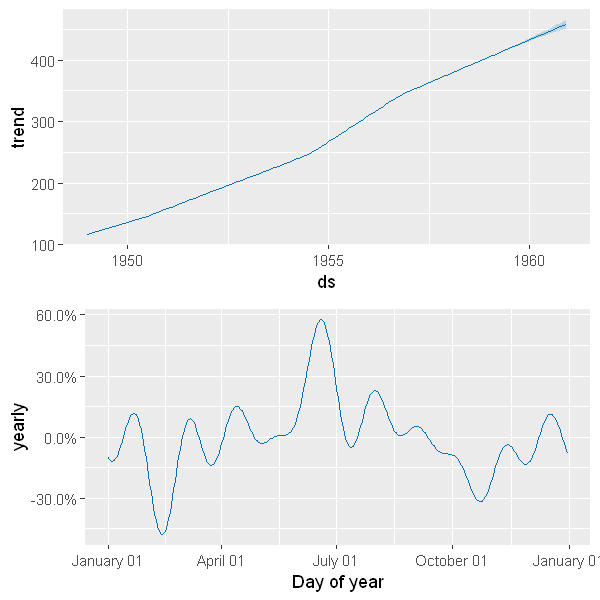

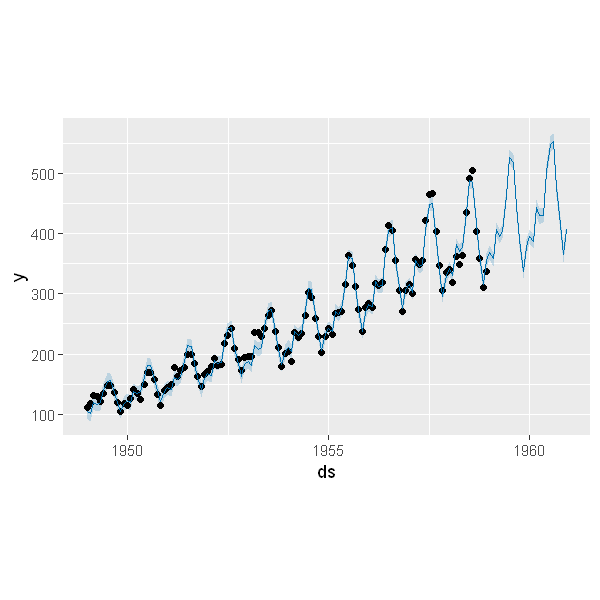

In [22]:
## Predict using prophet and plot the results 
## Creating future references
future = make_future_dataframe(prophet_model_fit,                      
                               periods = n_step_ahead,
                               freq = 'month')
forecasted_prophet = predict(prophet_model_fit,future)
forecasted_prophet = as.data.frame(forecasted_prophet)
## Creating prophet specific plot objectes
prophet_plot_components(prophet_model_fit, forecasted_prophet)         
plot(prophet_model_fit , forecasted_prophet)

In [23]:
### error calculation for prophet 
forecasted_prophet_1 = tail(forecasted_prophet,n_step_ahead)
prophet_mape = mape(forecasted_prophet_1$yhat , prophet_test$y)
prophet_mape

[1] 5.399866

# 9. Optimize the weights for all 3 algorithms using Genetic Algorithm

A genetic algorithm (GA) is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms (EA). Genetic algorithms are commonly used to generate high-quality solutions to optimize and search problems by relying on bio-inspired operators such as mutation, crossover and selection.

#### Optimizing objective:

    - Give proper weights to Holt-Winters, Arima & Prophet to combine the forecast. (Since we have 3 algorithms then the general way of combining the results will be to take an average ie., giving .3333 weights to all the 3, but we are optimizing these default weights only)
    - Minimize error function mape (defined above)
    - Define the lowest and highest weights for all the alogirthms (Only 2 weights will be specified as the last one is 1 - sumof other two)
    - maxiter: The maximum number of iterations to run before the GA search is halted
    - run: The number of consecutive generations without any improvement in the best fitness value before the GA is stopped
    
 There are also other parameters to tune the optimization - user can refer to the details of the algorithms 
 
 Ref: 
      - https://en.wikipedia.org/wiki/Genetic_algorithm
      - https://cran.r-project.org/web/packages/GA/vignettes/GA.html

In [24]:
##function to optimize
combine_func = function(w1, w2)
  {new_pred = w1*forecasted_hw$`Point Forecast` + (w2)*sarima_forecast$x + (1-w1 - w2)*forecasted_prophet_1$yhat
   x = mape(new_pred , test_series)
  return(-x)}

GA = ga("real-valued", fitness = function(x) combine_func(x[1], x[2]),
         lower = c(.01, .01), upper = c(.99, .99),
         maxiter = 1000, run = 500, seed = 123)

summary(GA)

-- Genetic Algorithm ------------------- 

GA settings: 
Type                  =  real-valued 
Population size       =  50 
Number of generations =  1000 
Elitism               =  2 
Crossover probability =  0.8 
Mutation probability  =  0.1 
Search domain = 
        x1   x2
lower 0.01 0.01
upper 0.99 0.99

GA results: 
Iterations             = 647 
Fitness function value = -2.763351 
Solution = 
            x1         x2
[1,] 0.5581346 0.09807721

#### Result of mape after combination

**Note:** Each time we run the GA the result of weights value can vary, hence the weights used here may not match with the other users when they are running this same script. The user is requested to use the appropriate weights got in the above step for further operations 

In [25]:
# check the revised mape
result = -combine_func(0.5581346 , 0.09807721)
result

[1] 2.763351

#### Comparing the results on test data

In [26]:
w1 = 0.5581346
w2 = 0.09807721
test_pred = w1*forecasted_hw$`Point Forecast` +
           w2*sarima_forecast$x+ 
          (1-w1-w2)*forecasted_prophet_1$yhat
test_pred = data.frame(pred = test_pred)
test_pred$hw_pred = forecasted_hw$`Point Forecast`
test_pred$sarima.pred = sarima_forecast$x
test_pred$prophet.pred = forecasted_prophet_1$yhat
test_pred$original = test_series
test_pred
test_pred %>% fwrite('test_prediction_results_v7.csv',row.names = F)

pred     hw_pred  sarima.pred prophet.pred original
1  360.0001 357.4257 345.3166    368.3686     360     
2  349.3916 347.9855 326.4318    358.2244     342     
3  408.3924 415.8636 374.5128    405.9284     406     
4  405.9820 420.2436 363.6798    394.8967     396     
5  427.3382 450.1588 379.7341    403.8699     420     
6  506.4770 542.5423 451.5227    463.6031     472     
7  566.2389 600.7385 508.9192    526.5817     548     
8  558.5083 589.3672 523.4070    518.4232     559     
9  457.5265 470.5749 425.7954    445.3949     463     
10 398.9131 407.8210 380.8083    389.6162     407     
11 343.1561 349.4992 331.9102    336.0663     362     
12 380.0245 384.6348 359.8429    378.2972     405     
13 399.2693 407.3591 367.5230    395.1924     417     
14 388.3893 396.0406 348.7814    387.2670     391     
15 454.9451 472.6390 395.6799    443.1268     419     
16 451.3768 476.9716 384.1979    428.9892     461     
17 471.9975 510.2490 401.1829    430.0990     472     
18 562.1747 614.1677 474.8013    502.6912     535     
19 619.5924 679.1838 532.3636    547.7318     622     
20 615.0090 665.4992 547.6481    552.2561     606     
21 503.6370 530.7145 448.0703    475.5295     508     
22 438.4699 459.3913 404.0002    414.3380     461     
23 379.8223 393.2337 355.8159    364.8977     390     
24 418.4156 432.2693 383.6126    405.8530     432

#### MAPE values : Holt Winters : 5.25%, SARIMA : 9.38%,  Prophet : 5.39% , combined resuls after GA : 2.76%
    - There is a significant decrease in the error value 

In [27]:
### mape calulation: if simple average was used instead of GA 
result = -combine_func(0.33333 , 0.33333)
result

[1] 3.811022

#### Simple average method Mape : 3.81%, Combined results after GA: 2.76%
    - The approach to find the weights using GA shows less error numbers than simple average method

# 10. Final Prediction

We will now use the entire data and recreate all the 3 models on this dataset, then use the weight from GA to combine the forecast and get the final prediction 

#### Steps
    - Build Holt winters model on last 10 years data
    - Build Sarima model on last 10 years data
    - Build Prophet model on last 10 years data
    - Use GA weights 
    - Get the final prediction for next 2 years

initial  value 2.589864 
iter   2 value 2.585865
iter   3 value 2.547623
iter   4 value 2.545741
iter   5 value 2.543350
iter   6 value 2.537264
iter   7 value 2.535490
iter   8 value 2.535196
iter   9 value 2.535065
iter  10 value 2.534720
iter  11 value 2.533530
iter  12 value 2.532833
iter  13 value 2.529299
iter  14 value 2.519887
iter  15 value 2.519344
iter  16 value 2.517633
iter  17 value 2.513788
iter  18 value 2.510995
iter  19 value 2.509985
iter  20 value 2.508687
iter  21 value 2.507529
iter  22 value 2.505912
iter  23 value 2.504286
iter  24 value 2.499862
iter  25 value 2.495347
iter  26 value 2.493731
iter  27 value 2.492996
iter  28 value 2.492428
iter  29 value 2.491742
iter  30 value 2.491152
iter  31 value 2.491132
iter  32 value 2.491130
iter  33 value 2.491129
iter  34 value 2.491127
iter  34 value 2.491127
iter  34 value 2.491127
final  value 2.491127 
converged
initial  value 2.491661 
iter   2 value 2.491279
iter   3 value 2.491144
iter   4 value 2.491092
iter 

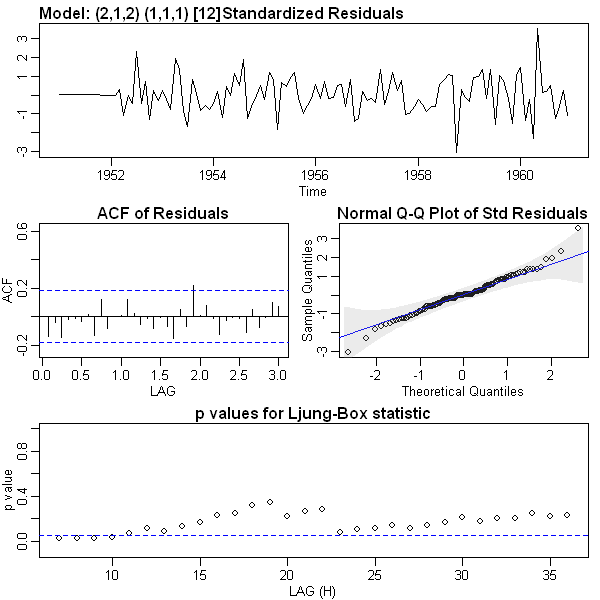

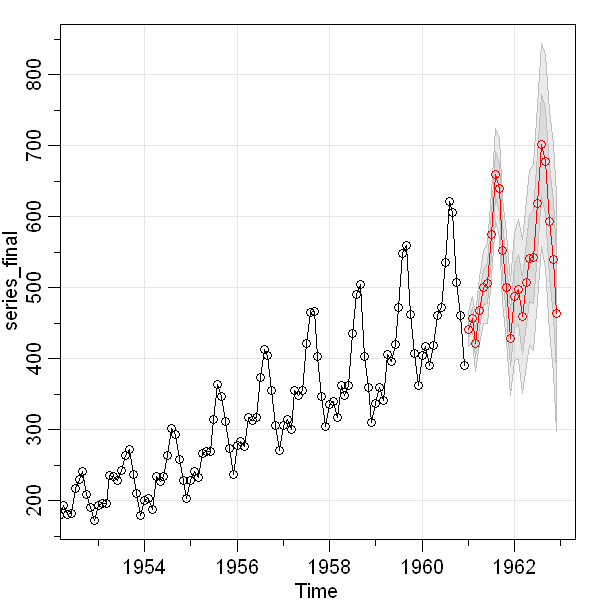

In [28]:
## Remodelling using full data
## ----------------------------------------------------------------------------------------------------------------------------

## We are now using only the last 10 years for the final modelling ( dropping first 2 years )
series_final = ts(series[24:length(series)],start = c(1951,1) , end = c(1960,12) , frequency = 12)

## HoltWinters
hw_model_fullData = HoltWinters(series_final, seasonal = 'multiplicative' , alpha = 0.5 , beta = 0.2)
forecasted_hw_fullData = forecast::forecast(hw_model_fullData, h = n_step_ahead)
## store the prediction in a dataset 
forecasted_hw_fullData = as.data.frame(forecasted_hw_fullData)

## Sarima
sarima_model_fullData = sarima(series_final , p = 2, d = 1, q = 2, P = 1, D = 1, Q = 1, S = 12)
## Forecasting using SARIMA
sarima_forecast_fullData = sarima.for(series_final , n.ahead = n_step_ahead,p = 2, d = 1, q = 2, P = 1, D = 1, Q = 1, S = 12)$pred

## store the prediction in a dataset 
sarima_forecast_fullData = as.data.frame(sarima_forecast_fullData)

## Prophet 
prophet_series_final = data.frame(ds = as.Date(time(series_final)),
                            y = coredata(series_final))

yearly_seasonality = TRUE
weekly_seasonality = FALSE
daily_seasonlity = FALSE
seasonality_type = 'multiplicative'
trend_type = 'linear'

prophet_model_fullData = prophet(yearly.seasonality = yearly_seasonality,
                        weekly.seasonality = weekly_seasonality,
                        daily.seasonality = daily_seasonlity,
                        growth = trend_type,
                        seasonality.mode = seasonality_type
)
prophet_model_fullData_fit = fit.prophet(prophet_model_fullData, df = prophet_series_final)

## Predict using prophet
future_forecast = make_future_dataframe(prophet_model_fullData_fit,                      ## Creating future references
                               periods = n_step_ahead,
                               freq = 'month')
forecasted_prophet_fullData = predict(prophet_model_fullData_fit,future_forecast)
## store the prediction in a dataset 
forecasted_prophet_fullData = as.data.frame(forecasted_prophet_fullData)
### select only the forecast data -  last 24 time points 
forecasted_prophet_fullData = forecasted_prophet_fullData  %>% tail(n_step_ahead)

#### Final weighted forecasts

In [29]:
#use the same weights to get the combined prediction 
w1 = 0.5581346
w2 = 0.09807721
new_pred = w1*forecasted_hw_fullData$`Point Forecast`+w2*sarima_forecast_fullData$x + (1-w1-w2)*forecasted_prophet_fullData$yhat

#### Save final prediction into a csv file

In [30]:
new_pred = data.frame(pred = new_pred, holt_winters = forecasted_hw_fullData$`Point Forecast`, 
                     sarima_forecast = sarima_forecast_fullData$x, 
                     prophet_forecast = forecasted_prophet_fullData$yhat)
new_pred  %>% fwrite("final_forecast_v7.csv", row.names = F)

#### Checking the final file at a glimpse

In [31]:
### top rows
new_pred  %>% head()

pred     holt_winters sarima_forecast prophet_forecast
1 448.3295 453.9265     441.0378        441.3230        
2 470.7467 484.7358     456.1770        452.1920        
3 457.7026 477.1328     421.8458        436.3873        
4 531.6519 565.3786     467.5845        495.1745        
5 550.7206 591.4396     500.6867        498.8877        
6 565.9543 610.9016     505.6338        510.1914

In [32]:
### last rows 
new_pred  %>% tail()

pred     holt_winters sarima_forecast prophet_forecast
19 740.2204 825.0355     619.0703        637.0865        
20 830.2747 919.1397     701.0236        722.8772        
21 808.6820 884.9838     677.7746        722.1530        
22 675.0672 728.6328     593.8900        611.2627        
23 595.9449 641.8575     540.4775        537.2307        
24 518.5090 558.6102     464.2813        468.8756

**Note:** The "pred" column is the final prediction after stacking 